In [ ]:
import cv2
import numpy as np
from math import *
import glob
import time
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from skimage.feature import hog
from sklearn.pipeline import Pipeline
%matplotlib inline
%load_ext autoreload
%autoreload 1
%load_ext line_profiler

from lesson_functions import *
np.random.seed(0xdeadbeef)

In [501]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

In [502]:
t=time.time()
cars = glob.iglob('data/vehicles/**/*.png')
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

notcars = glob.iglob('data/non-vehicles/**/*.png')
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features...')

66.86 Seconds to extract features...


In [503]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

In [504]:
# np.savez_compressed('training_data.npz', X=X, y=y)

In [505]:
# with np.load('training_data.npz') as data:
#     X = data['X']
#     y = data['y']

In [506]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0xdeadbeef)

In [509]:
clf = Pipeline([('scaling', StandardScaler()),
                ('feature_selection', SelectFromModel(ExtraTreesClassifier())),
                ('classification', LinearSVC()),
#                 ('classifier',SVC(kernel="rbf", probability=True))
               ])

# Check the training time for the SVC
t=time.time()
clf.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

9.64 Seconds to train SVC...


In [510]:
print('Test Accuracy of classifier = ', round(clf.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My classifier predicts: ', clf.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels')

Test Accuracy of classifier =  0.9629
My classifier predicts:  [ 0.  1.  0.  0.  0.  0.  1.  1.  1.  0.]
For these 10 labels:  [ 0.  1.  0.  0.  0.  0.  1.  1.  1.  0.]
0.00547 Seconds to predict 10 labels


In [469]:
from sklearn.externals import joblib
config = dict(color_space=color_space, 
            spatial_size=spatial_size, hist_bins=hist_bins, 
            orient=orient, pix_per_cell=pix_per_cell, 
            cell_per_block=cell_per_block, 
            hog_channel=hog_channel, spatial_feat=spatial_feat, 
            hist_feat=hist_feat, hog_feat=hog_feat)
# joblib.dump({'model':svc, 'config':config, 'scaler':X_scaler}, 'models/model_9919.pkl')
# joblib.dump({'model':svc, 'config':config}, 'models/clf_9805.pkl')
joblib.dump({'model':clf, 'config':config}, 'models/clf_9637_y.pkl')

['models/clf_9637_y.pkl']

In [373]:
from sklearn.externals import joblib
# data = joblib.load('models/model_9902.pkl')
data = joblib.load('models/clf_9892_ycbcr.pkl')
# svc = data['model']
clf = data['model']
config = data['config']
# X_scaler = data['scaler']

color_space = config['color_space']
spatial_size = config['spatial_size']
hist_bins = config['hist_bins']
orient = config['orient']
pix_per_cell = config['pix_per_cell']
cell_per_block = config['cell_per_block']
hog_channel = config['hog_channel']
spatial_feat = config['spatial_feat']
hist_feat = config['hist_feat']
hog_feat = config['hog_feat']
print(config)

{'hog_channel': 'ALL', 'cell_per_block': 2, 'hist_feat': True, 'spatial_size': (16, 16), 'pix_per_cell': 8, 'hist_bins': 16, 'spatial_feat': True, 'color_space': 'YCrCb', 'orient': 9, 'hog_feat': True}


In [281]:
def search_windows(img, windows, clf, color_space='RGB', 
                    spatial_size=None, hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    if spatial_size is None:
        spatial_size = (32, 32)

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    all_features = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = np.array(features).reshape(1, -1)

        #6) Predict using your classifier
        prediction = clf.predict(test_features)

        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows


In [458]:
def create_windows(pyramid):
    output = []
    for w_size, y_lims in pyramid:
        windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_lims, 
                        xy_window=w_size, xy_overlap=(0.5, 0.5))
        output.extend(windows)
    return output

def multiscale_detect(image, clf, config, windows, verbose=False):
    
    color_space = config['color_space']
    spatial_size = config['spatial_size']
    hist_bins = config['hist_bins']
    orient = config['orient']
    pix_per_cell = config['pix_per_cell']
    cell_per_block = config['cell_per_block']
    hog_channel = config['hog_channel']
    spatial_feat = config['spatial_feat']
    hist_feat = config['hist_feat']
    hog_feat = config['hog_feat']
    
    hot_windows = search_windows(image, windows, clf, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    
    return hot_windows

In [459]:
pyramid = [((64, 64),  [400, 500]),
           ((96, 96),  [400, 500]),
           ((128, 128),[400, 528]),
           ((192, 192),[400, None]),
#            ((256, 256),[400, None])
      ]
windows = create_windows(pyramid)

In [482]:
image = mpimg.imread('test_images/test1.jpg')
image = image.astype(np.float32)/255.

In [483]:
# %lprun -f single_img_features multiscale_detect(image, clf, config, windows)
t = time.time()
hot_windows = multiscale_detect(image, clf, config, windows)
t2 = time.time() - t 
print('Detected vehicles in %.2f seconds' % t2)
window_img = draw_boxes((image*255).astype(np.uint8), hot_windows, color=(255, 0, 0), thick=6)

Detected vehicles in 0.62 seconds


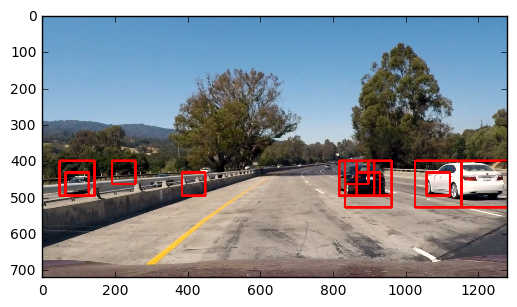

In [484]:
plt.imshow(window_img)
plt.show()

In [276]:
def process_image(image, clf, clf_config):
    pass